# Watershed Analysis

In [41]:
%matplotlib inline

import numpy as np
import hdf5storage
import matplotlib.pyplot as plt
import glob
import h5py

In [42]:
# graph-tool native installation
import sys
sys.path.append('/opt/homebrew/opt/graph-tool/lib/python3.11/site-packages')
from graph_tool.draw.cairo_draw import graph_draw

In [43]:
import motionmapperpy as mmpy

In [44]:
from data_factory import utils, processing, plotting

In [45]:
parameters = utils.set_parameters()
days = ['20210911', '20210912', '20210913', '20210914', '20210915', '20210916', '20210917', '20210918', '20210919', '20210920', '20210921', '20210922', '20210923', '20210924', '20210925', '20210926', '20210927', '20210928', '20210929', '20210930', '20211001', '20211002', '20211003', '20211004', '20211005', '20211006', '20211007', '20211008']
fish_keys = ['23442333_back', '23484201_back', '23484204_back', '23520257_back', '23520258_back', '23520264_back', '23520266_back', '23520268_back', '23520270_back', '23520276_back', '23520278_back', '23520289_back', '23442333_front', '23484201_front', '23484204_front', '23520257_front', '23520258_front', '23520264_front', '23520266_front', '23520268_front', '23520270_front', '23520276_front', '23520278_front', '23520289_front']
projectPath = parameters.projectPath
BLOCK = "block1"

Skipping, path already exists : /Users/marv/Documents/work/soi/data_backup/Fish_moves_new
Skipping, path already exists : /Users/marv/Documents/work/soi/data_backup/Fish_moves_new/Projections
Skipping, path already exists : /Users/marv/Documents/work/soi/data_backup/Fish_moves_new/TSNE_Projections
Skipping, path already exists : /Users/marv/Documents/work/soi/data_backup/Fish_moves_new/TSNE
Skipping, path already exists : /Users/marv/Documents/work/soi/data_backup/Fish_moves_new/UMAP


## Clusters

In [46]:
wshed_path = f'{projectPath}/UMAP/zVals_wShed_groups_10.mat'
wshedfile = hdf5storage.loadmat(wshed_path)

In [78]:
wshedfile?

Type:        dict
String form:
{'LL': array([[0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0 <...> .084972 ],
           [  9.626382 ,  -5.7205157],
           [ 10.2630825,  -5.020025 ]], dtype=float32)}
Length:      12
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

In [47]:
with h5py.File('/Users/marv/Documents/work/soi/data_backup/Fish_moves_new/UMAP/training_embedding.mat', 'r') as hfile:
    trainingEmbedding = hfile['trainingEmbedding'][:].T

## umap densities

In [48]:
m = np.abs(trainingEmbedding).max()
sigma=1.0
embedding_bounds, xx, density = mmpy.findPointDensity(trainingEmbedding, sigma, 511, [-m-10, m+10])

### density from trainingEmbeddings

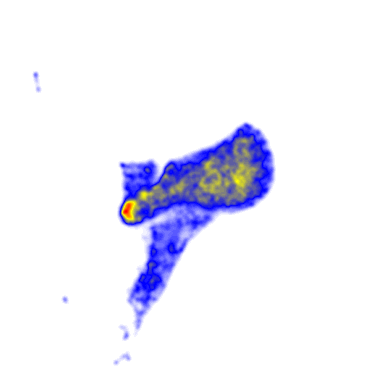

In [49]:
fig_test, ax_test = plt.subplots()
ax_test.imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')
ax_test.axis('off')
ax_test.scatter([],[],marker='o', c="b", s=300)
fig_test.show()


### density from watershedfile
(umap from all individuals throughout their whole lifetime)

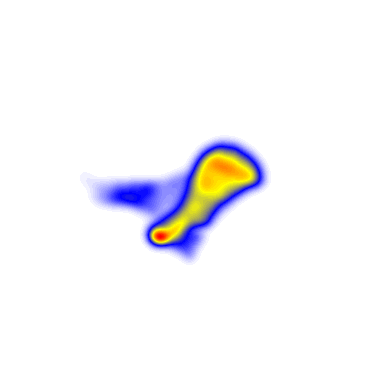

In [50]:
fig_test, ax_test = plt.subplots()
ax_test.imshow(wshedfile['density'], cmap=mmpy.gencmap(), extent=(wshedfile['xx'][0][0], wshedfile['xx'][0][-1], wshedfile['xx'][0][0], wshedfile['xx'][0][-1]), origin='lower')
ax_test.axis('off')
ax_test.scatter([],[],marker='o', c="b", s=300)
fig_test.show()


In [51]:
wshedfile['density'].shape

(611, 611)

## watershed clusters

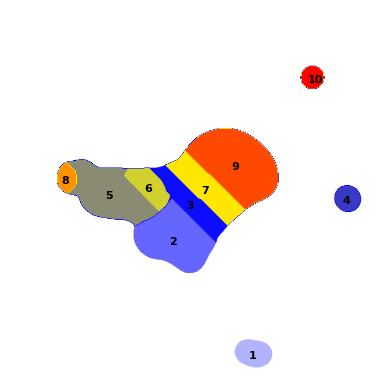

In [52]:
# plot bounds, and ids instead of densities
fig, ax = plt.subplots()
ax.imshow(wshedfile['LL'], origin='lower', cmap=mmpy.gencmap())

for i in np.unique(wshedfile['LL'])[1:]:
    fontsize = 8
    xinds, yinds = np.where(wshedfile['LL'] == i)
    ax.text(np.mean(yinds) - fontsize, np.mean(xinds) - fontsize, str(i), fontsize=fontsize, fontweight='bold')
    ax.axis('off')


(-0.5, 610.5, -0.5, 610.5)

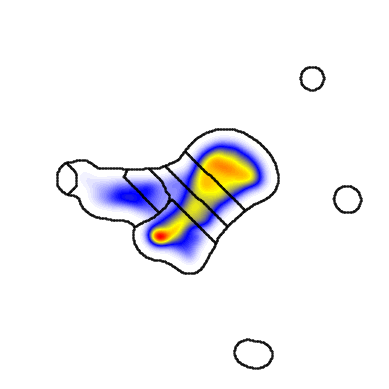

In [53]:
fig, ax = plt.subplots()
ax.imshow(wshedfile['density'], origin='lower', cmap=mmpy.gencmap())
ax.scatter(wshedfile['wbounds'][0][0], wshedfile['wbounds'][0][1], color='k', s=0.1)
ax.axis('off')

## watershed cluster boundaries

In [54]:
# individuals definitions
# 1
fish_key = '23442333_back'
day = '20211008'
# 2
fish_key_2 = '23484201_back'
day_2 = '20211008'
#
fish_key_3 = '23484204_back'
day_3 = '20211008'

In [55]:
def this_get_days(parameters, prefix=""):
    filepath = parameters.projectPath+f"/Projections/block1_{prefix}*_pcaModes.mat"
    files = glob.glob(filepath)
    return sorted(list(set(map(lambda f: "_".join(f.split("/")[-1].split("_")[3:5]),files))))

In [56]:
def this_load_trajectory_data(parameters,fk="", day=""):
    data_by_day = []
    filepath = parameters.projectPath+f'/Projections/block1_{fk}_{day}_060000_pcaModes.mat'
    pfile = glob.glob(filepath)
    pfile.sort()
    for f in pfile: 
        data = hdf5storage.loadmat(f)
        data_by_day.append(data)
    return data_by_day

def this_load_trajectory_data_concat(parameters,fk="", day=""):
    data_by_day = this_load_trajectory_data(parameters,fk, day)
    if len(data_by_day)==0:
        return None
    daily_df = 5*(60**2)*8 #get_num_tracked_frames_per_day()
    positions = np.concatenate([trj["positions"] for trj in data_by_day])
    projections = np.concatenate([trj["projections"] for trj in data_by_day])
    days = sorted(list(set(map(lambda d: d.split("_")[0], this_get_days(parameters, prefix=fk.split("_")[0])))))
    df_time_index = np.concatenate([trj["df_time_index"].flatten()+(daily_df*days.index(trj["day"].flatten()[0].split("_")[0])) for trj in data_by_day]) # 6h plus in the beginning ? TODO
    area = data_by_day[0]["area"]
    return dict(positions=positions, projections=projections, df_time_index=df_time_index, area=area)


In [57]:
def this_load_zVals(parameters,fk="", day=""):
    data_by_day = []
    zValstr = processing.get_zValues_str(parameters)
    pfile = glob.glob(parameters.projectPath+f'/Projections/block1_{fk}*_{day}*_pcaModes_{zValstr}.mat')
    pfile.sort()
    for f in pfile: 
        data = hdf5storage.loadmat(f)
        data_by_day.append(data)
    return data_by_day


def this_load_zVals_concat(parameters,fk="", day=""):
    zVals_by_day = this_load_zVals(parameters,fk, day)
    embeddings = None
    if len(zVals_by_day)==0:
        return dict(embeddings=embeddings)
    embeddings = np.concatenate([x["zValues"] for x in zVals_by_day])
    return dict(embeddings=embeddings)

In [58]:
# 1
data_dict = this_load_trajectory_data_concat(parameters, fish_key, day)
clusters_inp = processing.get_regions_for_fish_key(wshedfile, fish_key, day=day)
zVals_dict = this_load_zVals_concat(parameters, fish_key, day=day)
data_dict.update(dict(clusters=clusters_inp))
data_dict.update(zVals_dict)
sum_data = data_dict
zValues = sum_data['embeddings']
positions = sum_data['positions']
clusters = sum_data["clusters"]
area_box = sum_data['area']
#2
# individual 2
data_dict_2 = this_load_trajectory_data_concat(parameters, fish_key_2, day_2)
clusters_2_inp = processing.get_regions_for_fish_key(wshedfile, fish_key_2, day=day_2)
zVals_dict_2 = this_load_zVals_concat(parameters, fish_key_2, day=day_2)
data_dict_2.update(dict(clusters=clusters_2_inp))
data_dict_2.update(zVals_dict_2)
sum_data_2 = data_dict_2
zValues_2 = sum_data_2['embeddings']
positions_2 = sum_data_2['positions']
clusters_2 = sum_data_2["clusters"]
area_box_2 = sum_data_2['area']

# individual 3
data_dict_3 = this_load_trajectory_data_concat(parameters, fish_key_3, day_3)
clusters_3_inp = processing.get_regions_for_fish_key(wshedfile, fish_key_3, day=day_3)
zVals_dict_3 = this_load_zVals_concat(parameters, fish_key_3, day=day_3)
data_dict_3.update(dict(clusters=clusters_3_inp))
data_dict_3.update(zVals_dict_3)
sum_data_3 = data_dict_3
zValues_3 = sum_data_3['embeddings']
positions_3 = sum_data_3['positions']
clusters_3 = sum_data_3["clusters"]
area_box_3 = sum_data_3['area']

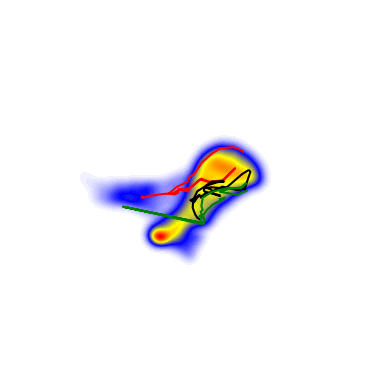

In [59]:
zValues_small = zValues[0:50]
zValues_2_small = zValues_2[0:50]
zValues_3_small = zValues_3[0:50]
fig, ax = plt.subplots()
ax.imshow(wshedfile['density'], cmap=mmpy.gencmap(), extent=(wshedfile['xx'][0][0], wshedfile['xx'][0][-1], wshedfile['xx'][0][0], wshedfile['xx'][0][-1]), origin='lower')
# ax.imshow(wshedfile['density'], cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')
ax.axis('off')
sc = ax.scatter([],[],marker='o', c="b", s=300)
ax.plot(zValues_small[:,0], zValues_small[:,1], color='red')
ax.plot(zValues_2_small[:,0], zValues_2_small[:,1], color='black')
ax.plot(zValues_3_small[:,0], zValues_3_small[:,1], color='green')



### image conversion for density + clusters + trajectories

In [60]:
from PIL import Image


In [61]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

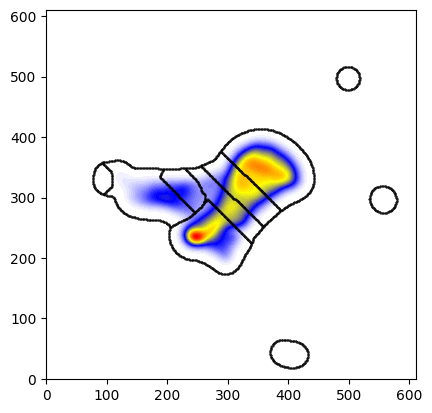

In [62]:
fig, ax = plt.subplots()
ax.imshow(wshedfile['density'], origin='lower', cmap=mmpy.gencmap())
ax.scatter(wshedfile['wbounds'][0][0], wshedfile['wbounds'][0][1], color='k', s=0.1)
# ax.axis('off')

img = fig2img(fig)

## Ethogram

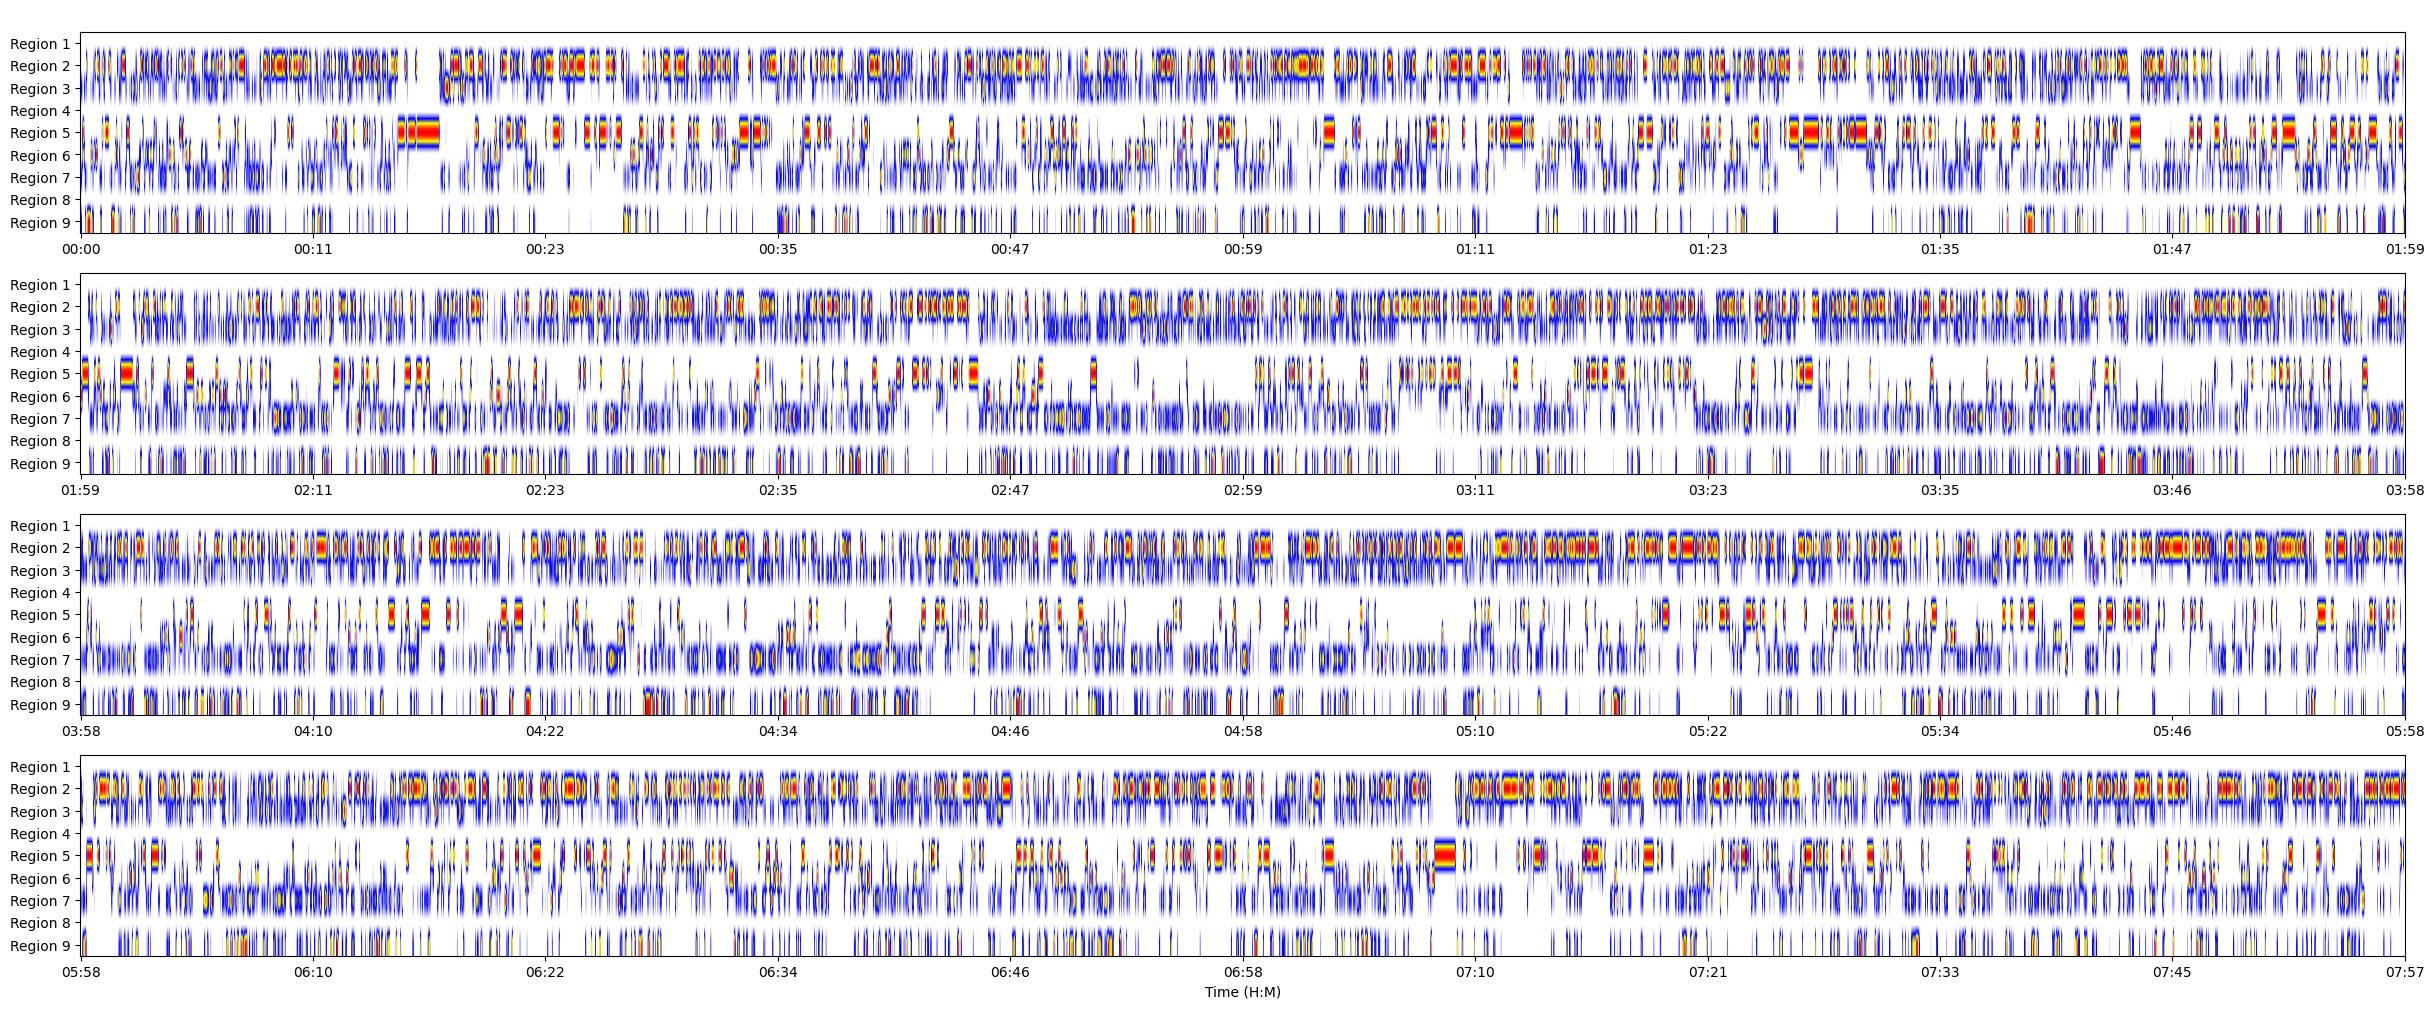

In [66]:
# ethnogram from watershed embedding

ethnogram_fig_10 = plotting.ethnogram_of_clusters(
    parameters= parameters,
    clusters= clusters,
)

## data analysis - watershed cluster boundaries
* plotting density + trajectories -> dimensional match in the figure
* plotting density + boundaries -> dimensional match in the figure
* plotting density + boundaries + trajectories -> dimensional MISmatch in the figure

1. correct density measure
* watershedfile density vs. finding PointDensity from trainingEmbeddings

    ```wshedfile['density'] !== (_, xx, density = mmpy.findPointDensity(trainingEmbedding, sigma, 511, [-m-10, m+10]))```
    * workflow: hpc_berman.factory_main() -> mmpy.findWatershedRegions(...,Projections/*_pcaModes.mat,...) -> watershedTransform(zValues...) -> findPointDensity(zValues...)
    * zValues vs. trainingEmbedding vs. trainingData vs. trainingAmps

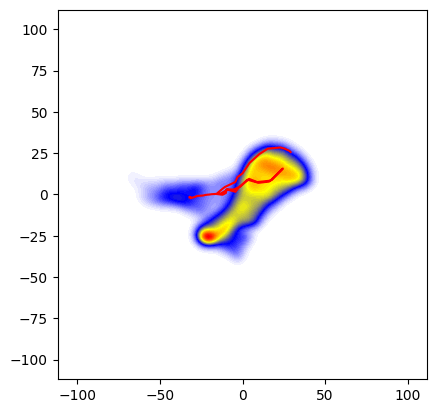

In [67]:
# m = np.abs(trainingEmbedding).max()
# sigma=1.0
# _, embedding_xx, embedding_density = mmpy.findPointDensity(trainingEmbedding, sigma, 511, [-m-10, m+10])

# fig_test, ax_test = plt.subplots()
# ax_test.imshow(embedding_density, cmap=mmpy.gencmap(), extent=(embedding_xx[0], embedding_xx[-1], embedding_xx[0], embedding_xx[-1]), origin='lower')
# ax_test.axis('off')
# ax_test.scatter([],[],marker='o', c="b", s=300)
# fig_test.show()


''' Using UMAP density from Watershed-File, includes sampling process
'''
fig_test, ax_test = plt.subplots()
# ax_test.imshow(wshedfile['density'], cmap=mmpy.gencmap(), origin='lower')
ax_test.imshow(wshedfile['density'], cmap=mmpy.gencmap(), extent=(wshedfile['xx'][0][0], wshedfile['xx'][0][-1], wshedfile['xx'][0][0], wshedfile['xx'][0][-1]), origin='lower')
ax_test.plot(zValues_small[:,0], zValues_small[:,1], color='red')
# ax_test.axis('off')

fig_test.show()

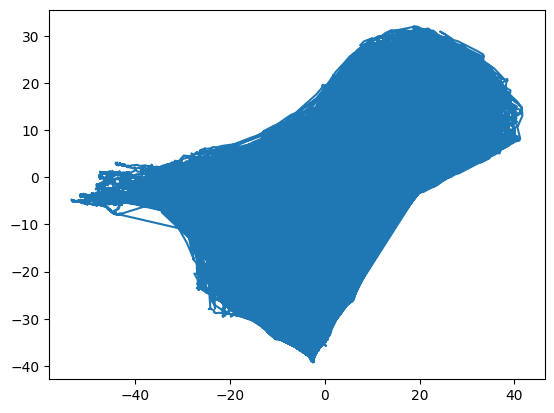

In [68]:
fig_test, ax_test = plt.subplots()
ax_test.plot(zValues[:,0], zValues[:,1])
# ax_test.imshow(wshedfile['density'], cmap=mmpy.gencmap(), extent=(wshedfile['xx'][0][0], wshedfile['xx'][0][-1], wshedfile['xx'][0][0], wshedfile['xx'][0][-1]), origin='lower')
# ax_test.axis('off')

fig_test.show()

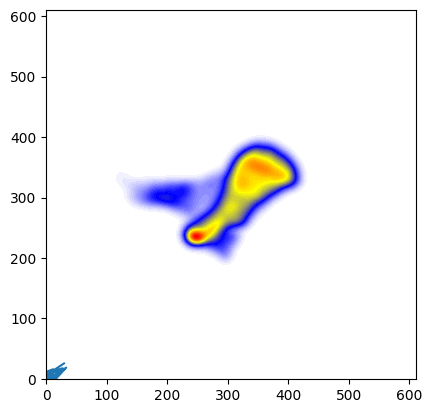

In [69]:
zvals_aug_x = zValues[:,0]
zvals_aug_x = zvals_aug_x[::5000]
# zvals_aug_x = zvals_aug_x + wshedfile['xx'][0][-1]


zvals_aug_y = zValues[:,1]
zvals_aug_y = zvals_aug_y[::5000]
# zvals_aug_y = zvals_aug_y + wshedfile['xx'][0][-1]

fig, ax = plt.subplots()
ax.plot(zvals_aug_x, zvals_aug_y)

ax.imshow(wshedfile['density'], origin='lower', cmap=mmpy.gencmap())
# ax.scatter(wshedfile['wbounds'][0][0], wshedfile['wbounds'][0][1], color='k', s=0.1)

fig.show()

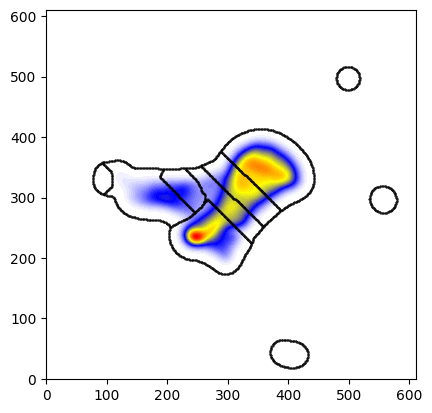

In [70]:
fig, ax = plt.subplots()
ax.imshow(wshedfile['density'], origin='lower', cmap=mmpy.gencmap())
ax.scatter(wshedfile['wbounds'][0][0], wshedfile['wbounds'][0][1], color='k', s=0.1)
# ax.plot(zValues_small[:,0], zValues_small[:,1], color='red')
# ax.axis('off')
fig.show()

#### shifting figure center
* density
* wshed_boundary

In [72]:
wshedfile['density'].shape[0]

611

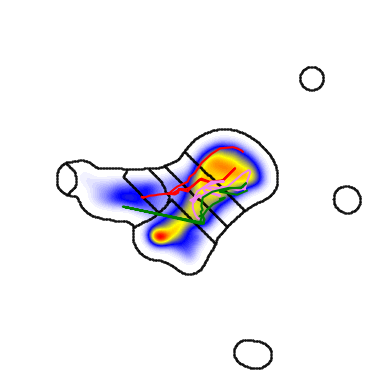

In [86]:
extent_factor = wshedfile['xx'][0][-1]
bounds_aug_x_new = ((wshedfile['wbounds'][0][0]
                     / (wshedfile['density'].shape[0]/(2*extent_factor))) 
                     - extent_factor
                    )
bounds_aug_y_new = ((wshedfile['wbounds'][0][1]
                     / (wshedfile['density'].shape[1]/(2*extent_factor))) 
                     - extent_factor)
# new_boundary  = old_boundary / (old_resolution/ 2*extent_factor) - extent_factor
#               = old_boundary / (old_resolution/ 2* half_extent_figure_size) - centering
#               = old_boundary / scaling_factor - centering


fig, ax = plt.subplots()
ax.imshow(wshedfile['density'],extent=(-extent_factor, extent_factor, -extent_factor, extent_factor), origin='lower', cmap=mmpy.gencmap())
ax.scatter(bounds_aug_x_new, bounds_aug_y_new, color='k', s=0.1)
ax.plot(zValues_small[:,0], zValues_small[:,1], color='red')
ax.plot(zValues_2_small[:,0], zValues_2_small[:,1], color='violet')
ax.plot(zValues_3_small[:,0], zValues_3_small[:,1], color='green')

ax.axis('off')
fig.show()


starting dimensions: 611x611, not centered
target dimensions: 111x111, centered at 0


2. dimensional sizes for density + trajectory


In [74]:
density_dict = {
    'type': 'density',
    'nr_of_points': wshedfile['density'].shape,
    'x_range': [wshedfile['density'][:,0].min(), wshedfile['density'][:,0].max()],
    'y_range': [wshedfile['density'][:,1].min(), wshedfile['density'][:,1].max()],
    'zValues_range': [-np.abs(zValues).max() - 15, np.abs(zValues).max() + 15],
    'extent_range': (wshedfile['xx'][0][0], wshedfile['xx'][0][-1], wshedfile['xx'][0][0], wshedfile['xx'][0][-1])
}

density_dict


{'type': 'density',
 'nr_of_points': (611, 611),
 'x_range': [0.0, 9.812298384226092e-14],
 'y_range': [0.0, 4.259664433425295e-14],
 'zValues_range': [-68.37405395507812, 68.37405395507812],
 'extent_range': (-111.88843536376953,
  111.88843536376953,
  -111.88843536376953,
  111.88843536376953)}

In [75]:
trajectory_dict = {
    'type': 'trajectory',
    'nr_of_points': len(zValues),
    'x_range': [zValues[:,0].min(), zValues[:,0].max()],
    'y_range': [zValues[:,1].min(), zValues[:,1].max()]
}

trajectory_dict


{'type': 'trajectory',
 'nr_of_points': 143357,
 'x_range': [-53.374054, 41.68881],
 'y_range': [-39.288147, 31.965334]}

3. dimensional sizes for watershed boundaries

In [76]:
wshed_boundaries_dict = {
    'type': 'wshed_boundaries',
    'nr_of_points': len(wshedfile['wbounds'][0][0][0]),
    'x_range': [wshedfile['wbounds'][0][0][0].min(), wshedfile['wbounds'][0][0][0].max()],
    'y_range': [wshedfile['wbounds'][0][1][0].min(), wshedfile['wbounds'][0][1][0].max()],
}
wshed_boundaries_dict

{'type': 'wshed_boundaries',
 'nr_of_points': 2751,
 'x_range': [77, 579],
 'y_range': [18, 516]}

In [77]:
import pandas as pd

pd.DataFrame([density_dict, trajectory_dict, wshed_boundaries_dict])

,type,nr_of_points,x_range,y_range,zValues_range,extent_range
0,density,"(611, 611)","[0.0, 9.812298384226092e-14]","[0.0, 4.259664433425295e-14]","[-68.37405395507812, 68.37405395507812]","(-111.88843536376953, 111.88843536376953, -111..."
1,trajectory,143357,"[-53.374054, 41.68881]","[-39.288147, 31.965334]",NaN,NaN
2,wshed_boundaries,2751,"[77, 579]","[18, 516]",NaN,NaN
